### Replacing the Linear Model
We are going to keep all the loss function, data, and optimizer intact. We are however going to replace our linear model with the simplest possible neural network:
* a linear module
* an activation function
* a linear module (fed from above)

The first linear layer and the activation function is referred to as a *hidden layer* since its outputs are not observed directly, but fed into the output layer.

`nn` provides a simple way to concatenate modules through the `nn.Sequential` container:

In [1]:
import torch
import torch.nn as nn

seq_model = nn.Sequential(
            nn.Linear(1, 13), # linear layer, input size =1 , output size = 13
            nn.Tanh(),        # tanh activation layer
            nn.Linear(13,1))  # output layer, input size = 13, output size = 1

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

#### Inspecting the parameters in the model
Calling `model.parameters()` will collect `weight` and `bias` from both the first and second linear modules.

In [2]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

#### Using Named Parameters
You can inspect the parameters of a model and idenitfy the parameters by name using the method `named_parameters()`

In [4]:
for name, param in seq_model.named_parameters():
    print(f"Parameter {name} has a shape of {param.shape}")

Parameter 0.weight has a shape of torch.Size([13, 1])
Parameter 0.bias has a shape of torch.Size([13])
Parameter 2.weight has a shape of torch.Size([1, 13])
Parameter 2.bias has a shape of torch.Size([1])


#### Using Named Modules
When creating our network, we can also use the type `OrderedDict` so that we can name each module passed to `nn.Sequential`.

In [5]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([ # pass in an ordered dictionary so we can assign keys to each layer
            ('hidden_linear', nn.Linear(1, 13)), 
            ('hidden_activation', nn.Tanh()),
            ('output_linear', nn.Linear(13, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [6]:
# this allows us to get more explanatory names for submodules
for name, param in seq_model.named_parameters():
    print(f"Parameter {name} has a shape of {param.shape}")

Parameter hidden_linear.weight has a shape of torch.Size([13, 1])
Parameter hidden_linear.bias has a shape of torch.Size([13])
Parameter output_linear.weight has a shape of torch.Size([1, 13])
Parameter output_linear.bias has a shape of torch.Size([1])


We can also now access a particular submodule, or a particular parameter of a submodule, using the submodule key as an attribute.

In [7]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0115], requires_grad=True)

### Using the Sequential model
First we need to bring back in our training loop and data

In [8]:
def training_loop(num_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, num_epochs + 1):
        t_p_train = model(t_u_train) # forward pass on training data
        loss_train = loss_fn(t_p_train, t_c_train) # evaluating the loss

        with torch.no_grad(): # we don't need a graph for validation - switch it off!
            t_p_val = model(t_u_val) # evaluating the validation data
            loss_val = loss_fn(t_p_val, t_c_val) # calculating loss for validation set

        optimizer.zero_grad() # zeroing the gradient
        loss_train.backward() # backward pass on loss_train
        optimizer.step() # update the parameters

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training Loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")


# TRAINING DATA -----------------------------------------------------------------------

#just copying our split data from the last chapter - t_u already normalized
t_c_train = torch.tensor([6.0, 13.0, 3.0, 11.0, 15.0, -4.0, 0.5, 21.0, 28.0])
t_u_train = torch.tensor([4.84, 6.04, 3.39, 5.63, 5.82, 2.18, 3.57, 6.84, 8.19])

t_c_val = torch.tensor([8.0, 14.0])
t_u_val = torch.tensor([4.89, 5.59])

# batching the data
t_c_train = t_c_train.unsqueeze(1)
t_u_train = t_u_train.unsqueeze(1)
t_c_val = t_c_val.unsqueeze(1)
t_u_val = t_u_val.unsqueeze(1)

t_c_train, t_u_train, t_c_val, t_u_val

(tensor([[ 6.0000],
         [13.0000],
         [ 3.0000],
         [11.0000],
         [15.0000],
         [-4.0000],
         [ 0.5000],
         [21.0000],
         [28.0000]]),
 tensor([[4.8400],
         [6.0400],
         [3.3900],
         [5.6300],
         [5.8200],
         [2.1800],
         [3.5700],
         [6.8400],
         [8.1900]]),
 tensor([[ 8.],
         [14.]]),
 tensor([[4.8900],
         [5.5900]]))

Now we can take our new model for a spin!

In [9]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    num_epochs= 5000,
    optimizer= optimizer,
    model= seq_model,
    loss_fn= nn.MSELoss(),
    t_u_train= t_u_train,
    t_u_val= t_u_val,
    t_c_train= t_c_train,
    t_c_val= t_c_val)

print('output', seq_model(t_u_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training Loss 200.7983, Validation loss 130.0504
Epoch 1000, Training Loss 4.0813, Validation loss 1.1596
Epoch 2000, Training Loss 3.4043, Validation loss 6.0905
Epoch 3000, Training Loss 2.2961, Validation loss 5.9296
Epoch 4000, Training Loss 1.8794, Validation loss 5.5609
Epoch 5000, Training Loss 1.8574, Validation loss 6.0020
output tensor([[ 7.6686],
        [12.0101]], grad_fn=<AddmmBackward0>)
answer tensor([[ 8.],
        [14.]])
hidden tensor([[ 2.2372e-01],
        [ 1.0629e+01],
        [-3.8342e+00],
        [ 4.5859e-01],
        [ 1.7140e+01],
        [-1.2473e+01],
        [ 3.3145e-01],
        [-1.7277e+01],
        [ 1.2325e+01],
        [ 1.0736e+01],
        [ 4.2180e-03],
        [ 2.3779e-01],
        [ 2.1052e-02]])


#### Comparing to the linear model

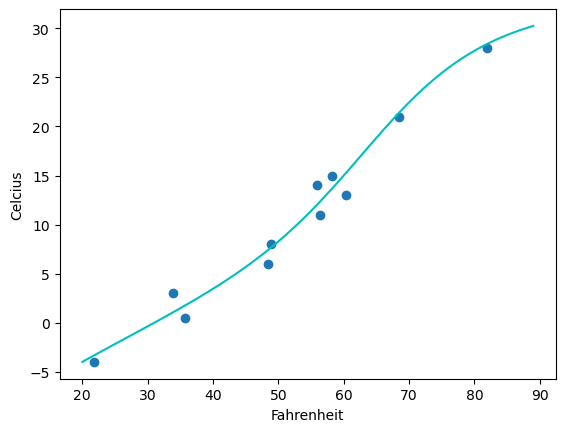

In [15]:
# Bringing our initial data back in to plot
# OUR DATA
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # temps in celcius

t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # temps in unknown unit

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celcius")

plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
